# CS5489 - Machine Learning
# Lecture 3a - Linear Classifiers
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Discriminative linear classifiers
2. Logistic regression
3. Support vector machines (SVM)

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

# Classification with Generative Model
- Steps to build a classifier
  1. Collect training data (features $\mathbf{x}$ and class labels $y$)
  2. Learn class-conditional distribution (CCD), $p(\mathbf{x}|y)$.
  3. Use Bayes' rule to calculate class probability, $p(y|\mathbf{x})$.
- **Note:** the data is used to learn the CCD -- the classifier is secondary.
  - Density estimation is an "ill-posed" problem -- which density to use?  how much data is needed?

- Advice from Vladimir Vapnik (inventor of SVM):
> When solving a problem, try to avoid solving a more general problem as an intermediate step.

- **Discriminative solution**
  - Solve for the classifier $p(y|\mathbf{x})$ directly!

- Terminology
  - **"Discriminative"** - learn to directly discriminate the classes apart using the features.
  - **"Generative"** - learn model of how the features are generated from different classes.

# Revisit the Naive Bayes Gaussian Classifier
- CCDs: assume the same variance for all Gaussians:
  - $p(\mathbf{x}|y=1) = \prod_{i=1}^D {\cal N}(x_i|\mu_i,\sigma^2)$
  - $p(\mathbf{x}|y=2) = \prod_{i=1}^D {\cal N}(x_i|\nu_i,\sigma^2)$
- prior:
  - $p(y=1) = \pi_1$, $p(y=2) = \pi_2$.



- look at the log-ratio of CCDs,
$$\begin{aligned} \log\frac{p(\mathbf{x}|y=1)}{p(\mathbf{x}|y=2)} &= \log \frac{\prod_{i=1}^D {\cal N}(x_i|\mu_i,\sigma^2)}{\prod_{i=1}^D {\cal N}(x_i|\nu_i,\sigma^2)}\\
&= \sum_{i=1}^D \log {\cal N}(x_i|\mu_i,\sigma^2) - \log {\cal N}(x_i|\nu_i,\sigma^2)\\
&=\sum_{i=1}^D -\frac{1}{2\sigma^2}(x_i -\mu_i)^2 +\frac{1}{2\sigma^2}(x_i -\nu_i)^2\\
&=\frac{1}{2\sigma^2}\sum_{i=1}^D (2x_i\mu_i-\mu_i^2-2x_i\nu_i +\nu_i^2)\\
&= \frac{1}{2\sigma^2}\sum_{i=1}^D 2(\mu_i-\nu_i)x_i - \mu_i^2 +\nu_i^2\end{aligned}$$

-  Thus
$$\begin{aligned} \log \frac{p(\mathbf{x}|y=1)}{p(\mathbf{x}|y=2)} = \frac{1}{\sigma^2}\sum_{i=1}^D (\mu_i - \nu_i)x_i + \frac{1}{2\sigma^2}\sum_{i=1}^D (\nu_i^2 -\mu_i^2)\end{aligned}$$

- **Bayes decision rule:** Compute the posterior probability of each class $p(y=j|\mathbf{x})$
  - select class 1 when:
$$ \begin{aligned}\log p(y=1|\mathbf{x}) &> \log p(y=2|\mathbf{x}) \\
  \log p(\mathbf{x}|y=1) + \log p(y=1) &> \log p(\mathbf{x}|y=2) + \log p(y=2) \\
 \log \frac{p(\mathbf{x}|y=1)}{p(\mathbf{x}|y=2)} + \log \frac{p(y=1)}{p(y=2)} &> 0 \end{aligned}$$

- substituting for the CCDs and priors, the BDR is:
  - select class $y=1$ when:
$$\sum_{i=1}^D \frac{1}{\sigma^2}(\mu_i - \nu_i)x_i + \frac{1}{2\sigma^2}\sum_{i=1}^D (\nu_i^2 -\mu_i^2) + \log \frac{\pi_1}{\pi_2} > 0$$


In [2]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris2.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (versicolor=1, virginica=2)

print(X.shape)

(100, 2)


In [3]:
# get the NB Gaussian model from sklearn
model = naive_bayes.GaussianNB()

# fit the model
model.fit(X, Y)
v = mean(model.sigma_.ravel())  # make it shared variance
model.sigma_[:] = v

In [4]:
# a colormap for making the scatter plot: class 1 will be red, class 2 will be green
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

axbox = [2.5, 7, 1.5, 4] # common axis range

# a function for setting a common plot
def irisaxis():
    plt.xlabel('petal length'); plt.ylabel('sepal width')
    plt.axis([2.5, 7, 1.5, 4]); plt.grid(True)

In [5]:
## Visualization  ###############################################################################################
def plot_ellipse(ax, musigma, color="k", lw=1):
    """
    Based on
    http://stackoverflow.com/questions/17952171/not-sure-how-to-fit-data-with-a-gaussian-python.
    """

    mu, sigma = musigma
    
    # Compute eigenvalues and associated eigenvectors
    vals, vecs = linalg.eigh(sigma)

    # Compute "tilt" of ellipse using first eigenvector
    x, y = vecs[:, 0]
    theta = degrees(arctan2(y, x))

    # Eigenvalues give length of ellipse along each eigenvector
    # plot 2 stdevs
    w, h = 2 * sqrt(vals) * 2

    #ax.tick_params(axis='both', which='major', labelsize=20)
    ellipse = matplotlib.patches.Ellipse(mu, w, h, theta, fill=False, color=color, lw=lw)  # color="k")
    ellipse.set_clip_box(ax.bbox)
    ellipse.set_alpha(1.0)
    ax.add_artist(ellipse) 

In [6]:
def plot_posterior(model, axbox, mycmap, showlabels=True):
    xr = [ linspace(axbox[0], axbox[1], 200), 
           linspace(axbox[2], axbox[3], 200) ]

    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # calculate the posterior probability
    post = model.predict_proba(allpts)
    # extract the posterior for class 2, and reshape into a grid
    post1 = post[:,1].reshape(xgrid0.shape)

    # contour plot of the posterior and decision boundary
    plt.imshow(post1, origin='lower', extent=axbox, alpha=0.50, cmap=mycmap)
    if showlabels:
        plt.colorbar(shrink=0.6)
    CS = plt.contour(xr[0], xr[1], post1, cmap=mycmap, levels=[0.1, 0.3, 0.7, 0.9], alpha=0.8)
    if showlabels:
        #plt.colorbar(CS)
        plt.clabel(CS, inline=1, fontsize=10)
    plt.contour(xr[0], xr[1], post1, levels=[0.5], linestyles='dashed', colors='black')
    irisaxis()

In [7]:
pfig = plt.figure(figsize=(9,8))
plot_posterior(model, axbox, mycmap, showlabels=True)
plot_ellipse(plt.gca(), (model.theta_[0,:], diag(model.sigma_[0,:])), color='r')
plot_ellipse(plt.gca(), (model.theta_[1,:], diag(model.sigma_[1,:])), color='g')
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
plt.title('posterior p(y=2|x) with training data');
plt.close()

- Example

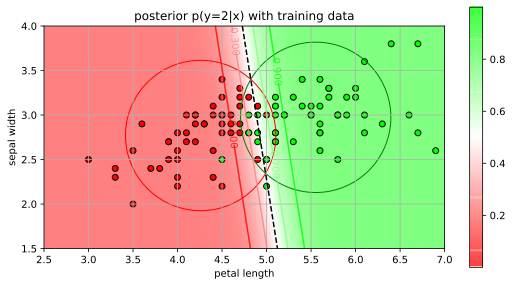

In [8]:
pfig

- BDR in this case is a **linear** function
  - select class $y=1$ when:
$$\sum_{i=1}^D \underbrace{\frac{1}{\sigma^2}(\mu_i - \nu_i)}_{w_i}x_i + \underbrace{\frac{1}{2\sigma^2}\sum_{i=1}^D (\nu_i^2 -\mu_i^2) + \log \frac{\pi_1}{\pi_2}}_{b} > 0$$
    - $w_i$ is a per-feature weight
    - $b$ is a bias term

- the BDR in this case is a **linear** classifier:
  - select class $y=1$ when
    - $\sum_{i=1}^D w_i x_i + b > 0 $
    - equivalently, $f(\mathbf{x}) = \mathbf{w}^T \mathbf{x} + b > 0$
- Here we obtain the weights $\mathbf{w}$ by learning the CCDs
  - assuming Naive Bayes Gaussians with shared variance.
  - this is a generative model since we learn how the data is generated for each class (CCDs).

- How to learn the linear classifier in a discriminative way?
  - directly learn the posterior $p(y|\mathbf{x})$.
  - we will look at a generic linear classifier.

# Linear Classifier
- **Setup**
  - Observation (feature vectors) $\mathbf{x}\in \mathbb{R}^d$
  - Class $y \in \{-1, +1\}$
- **Goal**: given a feature vector $\mathbf{x}$, predict its class $y$.
  - Calculate a _linear function_ of the feature vector $\mathbf{x}$.
    - $f(\mathbf{x}) = \mathbf{w}^T \mathbf{x} + b = \sum_{j=1}^d w_j x_j + b$
      - $\mathbf{w}\in \mathbb{R}^d$ are the weights of the linear function.
      - multiply each feature value with a weight, and then add together.
  - Predict from the value:
    - if $f(\mathbf{x}) > 0$ then predict Class $y=1$
    - if $f(\mathbf{x}) < 0$ then predict Class $y=-1$
    - Equivalently, $y = \mathrm{sign}(f(\mathbf{x}))$

# Geometric Interpretation
- The linear classifier separates the features space into 2 _half-spaces_
  - corresponding to feature values belonging to Class +1 and Class -1
  - the class boundary is normal to $\mathbf{w}$.
    - also called the _separating hyperplane_.

  - Example: 
  $$\mathbf{w} = \begin{bmatrix}2\\1\end{bmatrix}, b=0$$

In [9]:
def drawplane(w, b, wlabel=None, poscol=None, negcol=None):
    # w^Tx + b = 0
    # w0 x0 + w1 x1 + b = 0
    # x1 = -w0/w1 x0 - b / w1

    # the line
    x0 = linspace(-10,10)
    x1 = -w[0]/w[1] * x0 - b / w[1]
    
    
    # fill positive half-space or neg space
    if (poscol):
        polyx = [x0[0], x0[-1], x0[-1], x0[0]]
        polyy = [x1[0], x1[-1], x1[0], x1[0]]
        plt.fill(polyx, polyy, poscol, alpha=0.2)
    
    if (negcol):
        polyx = [x0[0], x0[-1], x0[0], x0[0]]
        polyy = [x1[0], x1[-1], x1[-1], x1[0]]
        plt.fill(polyx, polyy, negcol, alpha=0.2)
        
    # plot line
    plt.plot(x0, x1, 'k-', lw=2)

    # the w
    if (wlabel):
        xp = array([0, -b/w[1]])
        xpw = xp+w
        plt.arrow(xp[0], xp[1], w[0], w[1], width=0.01, head_width=0.3, fc='black')
        plt.text(xpw[0]-0.5, xpw[1], wlabel)
    

In [10]:
linclass = plt.figure()
w = array([2, 1])
b = 0;

drawplane(w, b, '$\mathbf{w}$', 'b', 'r')

# a few points
plt.plot([2.2,4,3], [-2,2,-1], 'bx')
plt.plot([-2.2,-4,-3], [2,1,-1], 'ro')

plt.text(-1.8,4, "$f(\mathbf{x}) = 0$", fontsize=12)
plt.text(4, 3.5, "$f(\mathbf{x})>0$\nclass +1", ha="right", fontsize=12)
plt.text(-4, -3.5, "$f(\mathbf{x})<0$\nclass -1", fontsize=12)

plt.xlabel('feature $x_1$'); plt.ylabel('feature $x_2$')
plt.axis('equal')
plt.axis([-5, 5, -5, 5]); plt.grid(True)
plt.close()

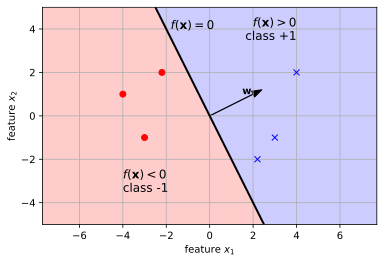

In [11]:
linclass

# Separating Hyperplane
- In a $d$-dimensional feature space, the parameters are $\mathbf{w}\in\mathbb{R}^d$.
- The equation $\mathbf{w}^T\mathbf{x} + b = 0$ defines a $(d-1)$-dim. linear surface:
  - for $d=2$, $\mathbf{w}$ defines a 1-D line.
  - for $d=3$, $\mathbf{w}$ defines a 2-D plane.
  - ...
  - in general, we call it a hyperplane.


# Learning the classifier
- How to set the classifier parameters $(\mathbf{w}, b)$?
  - Learn them from training data!
- Classifiers differ in the objectives used to learn the parameters $(\mathbf{w},b)$.
  - We will look at two examples:
    - _logistic regression_
    - _support vector machine (SVM)_

# Logistic regression
- Use a probabilistic approach
  - Map the linear function $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b$ to probability values between 0 and 1 using a _sigmoid_ function.
  - $\sigma(z) = \frac{1}{1+e^{-z}}$

In [12]:
z = linspace(-5,5)
sigz = 1/(1+exp(-z))

sigmoidplot = plt.figure(figsize=(5,3))

plt.plot(z,sigz, 'b-')

plt.xlabel('$f(\mathbf{x})$'); plt.ylabel('$\sigma(f(\mathbf{x}))$')
plt.axis([-5, 5, 0, 1]); plt.grid(True)
plt.close()

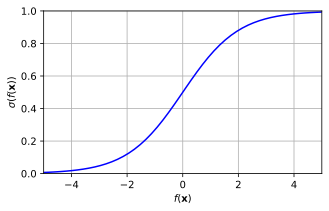

In [13]:
sigmoidplot

- Given a feature vector $x$, the probability of a class is:
  - $p(y=+1|\mathbf{x}) = \sigma( f(\mathbf{x}) )$
  - $p(y=-1|\mathbf{x}) = 1-\sigma( f(\mathbf{x}) )$
- Note: here we are directly modeling the class posterior probability!
  - not the class-conditional $p(\mathbf{x}|y)$

In [14]:
x = linspace(-10,10, 100)
w = 2.0
b = -4.0
f = w*x+b
sf = 1/(1+exp(-f))
midx = -b/w

lrexample = plt.figure(figsize=(6,3))

plt.plot(x,sf, 'b-', label="$p(y=+1|\mathbf{x})$")
plt.plot(x,1-sf, 'r-', label="$p(y=-1|\mathbf{x})$")
plt.plot([midx, midx], [0.0,1.2], 'k--', label="decision boundary")

plt.arrow(midx-0.1,1.05,-1.8,0,width=0.01)
plt.arrow(midx+0.1,1.05,1.8,0,width=0.01)
plt.text(midx+0.2,1.10,"Class +1")
plt.text(midx-0.2,1.10,"Class -1", horizontalalignment='right')
plt.legend(loc=0, framealpha=1, fontsize='medium')
plt.title('class posterior $p(y|\mathbf{x})$');
plt.xlabel('feature $\mathbf{x}$'); plt.ylabel('probability')
plt.axis([-7, 7, 0, 1.2]); plt.grid(True)
plt.close()

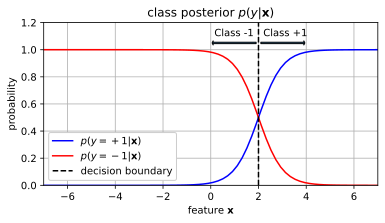

In [15]:
lrexample

# Learning the parameters
- Given training data $\{\mathbf{x}_i,y_i\}_{i=1}^N$, learn the function parameters $(\mathbf{w},b)$ using maximum likelihood estimation.
- maximize the likelihood of the data $\{\mathbf{x}_i,y_i\}$ according to the posterior:
  $$(\mathbf{w}^*,b^*) = \mathop{\mathrm{argmax}}_{\mathbf{w},b} \sum_{i=1}^N \log p(y_i|\mathbf{x}_i)$$

- posterior is a Bernoulli distribution (given $\mathbf{x}$):
  $$p(y|\mathbf{x}) = \begin{cases}\sigma(f(\mathbf{x})), & y=1 \\ 1-\sigma(f(\mathbf{x})), & y=-1\end{cases}$$
    

- Note the following property:
  $$1-\sigma(z)=\sigma(-z)$$

In [16]:
z = linspace(-5,5)
sigz = 1/(1+exp(-z))
signz = 1/(1+exp(z))

sigmoidplot = plt.figure(figsize=(5,3))

plt.plot(z,sigz, 'b-', label='$\sigma(z)$')
plt.plot(z,signz, 'r-', label='$\sigma(-z) = 1-\sigma(z)$')

plt.xlabel('$f(\mathbf{x})$');
plt.axis([-5, 5, 0, 1]); plt.grid(True)
plt.legend()
plt.close()

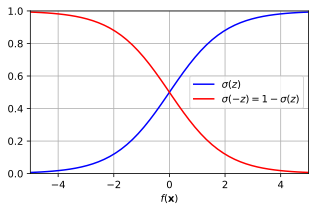

In [17]:
sigmoidplot

- Thus,
  $$p(y|\mathbf{x}) = \begin{cases}\sigma(f(\mathbf{x})), & y=1 \\ \sigma(-f(\mathbf{x})), & y=-1\end{cases}$$
- Simplifying the 2 cases into one equation,
  $$p(y|\mathbf{x}) = \sigma(y f(\mathbf{x}))$$

    

- Taking the log,
$$\begin{aligned}\log p(y|\mathbf{x}) &= \log \sigma(y f(\mathbf{x})) \\
    &= \log \frac{1}{1+e^{-y f(\mathbf{x})}} \\
    &= -\log (1+e^{-y f(\mathbf{x})}) \end{aligned}$$

- Substituting into the MLE formulation:
$$\begin{aligned}(\mathbf{w}^*,b^*) &= \mathop{\mathrm{argmax}}_{\mathbf{w},b} \sum_{i=1}^N \log p(y_i|\mathbf{x}_i) \\ 
 &= \mathop{\mathrm{argmin}}_{\mathbf{w},b} \sum_{i=1}^N \log (1+e^{-y_i f(\mathbf{x}_i)}) \end{aligned}$$



- the term on the right is a _data-fit term_
    - wants to make the parameters $(\mathbf{w},b)$ to well fit the data.
    - Define $z_i = y_i f(\mathbf{x}_i)$
      - Interesting observation:
        - $z_i > 0$ when sample $\mathbf{x}_i$ is classified correctly
        - $z_i < 0$ when sample $\mathbf{x}_i$ is classified incorrectly
        - $z_i = 0$ when sample is on classifier boundary
    - logistic loss function: $L(z_i) = \log (1+\exp(-z_i))$

In [18]:
z = linspace(-6,6,100)
logloss = log(1+exp(-z)) / log(2)
lossfig = plt.figure()
plt.plot(z,logloss, 'b-')
plt.plot([0,0], [0,9], 'k--')
plt.text(0,8.5, "incorrectly classified $\\Leftarrow$ ", ha='right', weight='bold')
plt.text(0,8.5, " $\Rightarrow$ correctly classified", ha='left', weight='bold')
plt.annotate(text="large loss for badly\nmisclassified samples", 
             xy=(-4,5.8), xytext=(-4.5,7.2),backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.annotate(text="non-zero loss for correctly\nclassified samples\nthat are near boundary", 
             xy=(1,0.5), xytext=(0.5,3.2), backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.xlabel('$z_i$'); plt.ylabel('loss')
plt.title('logistic loss');  plt.grid(True)
plt.xlim(-6,6)
plt.close()

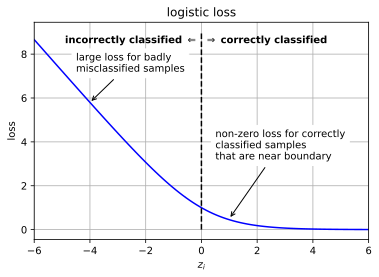

In [19]:
lossfig

# Regularization

- to prevent *overfitting*, add a prior distribution on $\mathbf{w}$.
  - prefer solutions that are likely under the prior.
  $$(\mathbf{w}^*,b^*) = \mathop{\mathrm{argmax}}_{\mathbf{w},b} \log p(\mathbf{w}) + \sum_{i=1}^N \log p(y_i|\mathbf{x}_i)$$




- assume Gaussian distribution on $\mathbf{w}$ with variance $C/2$
    - $p(\mathbf{w}) = {\cal N}(\mathbf{w}|0,\frac{C}{2}\mathbf{I})$
      - small values of $C$ keep $\mathbf{w}$ close to 0.
      - large values of $C$ allow larger values of $\mathbf{w}$.
    - $\log p(\mathbf{w}) = -\frac{1}{C} \mathbf{w}^T\mathbf{w} + \text{constant}$

<center><img src="imgs/GaussianPlot.svg" width=400></center>

- Substituting, 
  $$(\mathbf{w}^*,b^*) = \mathop{\mathrm{argmin}}_{\mathbf{w},b} \frac{1}{C} \mathbf{w}^T\mathbf{w} + \sum_{i=1}^N \log (1+\exp(-y_i f(\mathbf{x}_i))$$
- the first term is the _regularization term_
  - Note: $\mathbf{w}^T\mathbf{w} = \sum_{j=1}^d w_j^2$
  - penalty term that keeps entries in $\mathbf{w}$ from getting too large.
  - $C$ is the regularization _hyperparameter_
    - larger $C$ values apply less penalty on large $\mathbf{w}$ &rarr; allow large values in $\mathbf{w}$.
    - smaller $C$ values apply more penalty on large $\mathbf{w}$ &rarr; discourage large values in $\mathbf{w}$.
- the second term is the _data fit term_ - same as before.

# Optimization

- **no closed-form solution**
  - use an iterative optimization algorithm to find the optimal solution
  - e.g., _gradient descent_ - step downhill in each iteration.
    - $\mathbf{w} \leftarrow \mathbf{w} - \eta \frac{d E}{d\mathbf{w}}$
    - where $E$ is the objective function
    - $\eta$ is the _learning rate_ (how far to step in each iteration).
<center><img src="imgs/graddescent.png" width=400></center>

# Example: Iris Data

In [20]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris2.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (versicolor=1, virginica=2) 
                     #  --> automaticaly mapped to (-1, +1) when training classifier

print(X.shape)

(100, 2)


In [21]:
# a colormap for making the scatter plot: class -1 will be red, class +1 will be green
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

axbox = [2.5, 7, 1.5, 4] # common axis range

# a function for setting a common plot
def irisaxis(axbox):
    plt.xlabel('petal length'); plt.ylabel('sepal width')
    plt.axis(axbox); plt.grid(True)

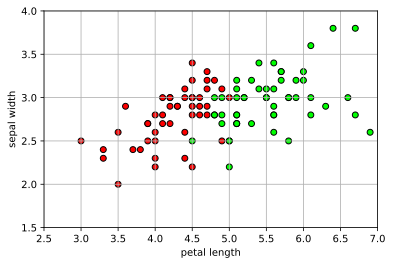

In [22]:
# show the data
plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
irisaxis(axbox)

In [23]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.5, test_size=0.5, random_state=4487)

print(trainX.shape)
print(testX.shape)

(50, 2)
(50, 2)


In [24]:
# learn logistic regression classifier
# (C is a regularization hyperparameter)
logreg = linear_model.LogisticRegression(C=100)
logreg.fit(trainX, trainY)

print("w =", logreg.coef_)
print("b =", logreg.intercept_)

w = [[9.51275841 0.89596567]]
b = [-48.68254369]


- Equation:
  - $f(\mathbf{x}) = (4.87 * \mathrm{petal\_length}) - (0.62 * \mathrm{sepal\_width}) - 21.68$
- Interpretation:
  - large petal length makes $f(\mathbf{x})$ positive, so large petal length is associated with class +1.

In [25]:
def plot_posterior(model, axbox, mycmap, showlabels=True):
    xr = [ linspace(axbox[0], axbox[1], 200), 
           linspace(axbox[2], axbox[3], 200) ]

    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # calculate the posterior probability
    post = model.predict_proba(allpts)
    # extract the posterior for class 2, and reshape into a grid
    post1 = post[:,1].reshape(xgrid0.shape)

    # contour plot of the posterior and decision boundary
    plt.imshow(post1, origin='lower', extent=axbox, alpha=0.50, cmap=mycmap, vmin=0.0, vmax=1.0)
    if showlabels:
        plt.colorbar(shrink=0.6)
    CS = plt.contour(xr[0], xr[1], post1, colors='k', linestyles='dashed', levels=[0.1, 0.3, 0.7, 0.9], alpha=0.8, linewidths=1)
    if showlabels:
        #plt.colorbar(CS)
        plt.clabel(CS, inline=1, fontsize=10)
    plt.contour(xr[0], xr[1], post1, levels=[0.5], linewidths=2, colors='black')
    irisaxis(axbox)


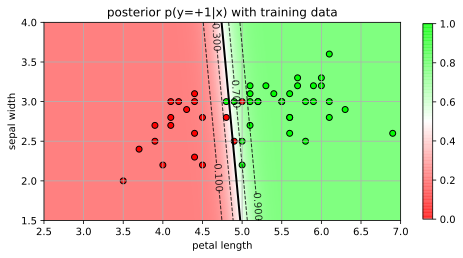

In [26]:
# show the posterior and training data
plt.figure(figsize=(8,6))
plot_posterior(logreg, axbox, mycmap)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.title('posterior p(y=+1|x) with training data');

In [27]:
# predict from the model
predY = logreg.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print("test accuracy =", acc)

test accuracy = 0.92


In [28]:
# show the posterior and training data
postfig = plt.figure(figsize=(8,6))
plot_posterior(logreg, axbox, mycmap)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, marker="o", label="training", edgecolors='k')
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap, marker="s", label="testing", edgecolors='k')
plt.title('posterior p(y=+1|x) with testing data');
plt.legend(loc=0);
plt.close()

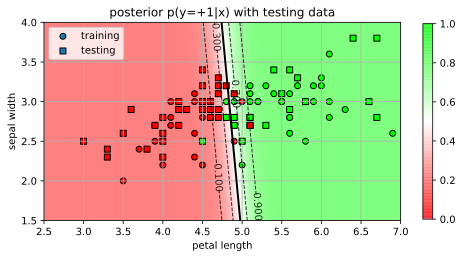

In [29]:
postfig

# Selecting the regularization hyperparameter
- the regularization hyperparameter $C$ has a large effect on the decision boundary and the accuracy.
  - larger $C$ makes the classifier more confident (posterior probabilities saturate to 0 and 1)
    - more likely to overfit
  - smaller $C$ makes the classifer less confident (wider range of posterior probabilities).
    - less likely to overfit
- How to set the value of $C$?

In [30]:
lrC = plt.figure(figsize=(10,4.5))

allC = [10000,100, 10, 1, 0.1, 0.01]
for (myCind,myC) in enumerate(allC):
    logreg = linear_model.LogisticRegression(C=myC)
    logreg.fit(trainX, trainY)
    
    # predict from the model
    predY = logreg.predict(testX)

    # calculate accuracy
    acc = metrics.accuracy_score(testY, predY)
    
    plt.subplot(2,3,myCind+1)
    plot_posterior(logreg, axbox, mycmap, showlabels=False)
    plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
    plt.title('C='+str(myC)+"; acc="+str(acc));
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
plt.close()

/Users/abc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/Users/abc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: No contour levels were found within the data range.


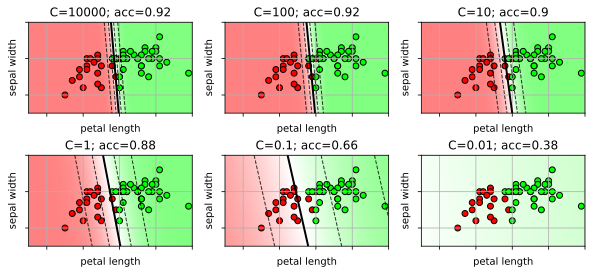

In [31]:
lrC

# Cross-validation
- Use _cross-validation_ on the training set to select the best value of $C$.
  - Run many experiments on the training set to see which parameters work on different versions of the data.
    - Split the data into batches of training and validation data.
    - Try a range of $C$ values on each split.
    - Pick the value that works best over all splits.
<center><img src="imgs/10_fold_cv.png" width="500px"/></center>

- **Procedure**
  1. select a range of $C$ values to try
  2. Repeat $K$ times
    1. Split the training set into training data and validation data
    2. Learn a classifier for each value of $C$
    3. Record the accuracy on the validation data for each $C$
  3. Select the value of $C$ that has the highest average accuracy over all $K$ folds.
  4. Retrain the classifier using all data and the selected $C$.

- scikit-learn already has built-in `cross_validation` module (more later).
- for logistic regression, use _LogisticRegressionCV_ class

In [32]:
# learn logistic regression classifier using CV
#  Cs is an array of possible C values
#  cv is the number of folds
#  n_jobs=-1 means run in parallel with all cores
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
logreg.fit(trainX, trainY)

print("w=", logreg.coef_)
print("b=", logreg.intercept_)

# predict from the model
predY = logreg.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print("test accuracy=", acc)

w= [[4.61911023 0.72397804]]
b= [-24.24716682]
test accuracy= 0.9


# Which C was selected?

C = [4.2813324]


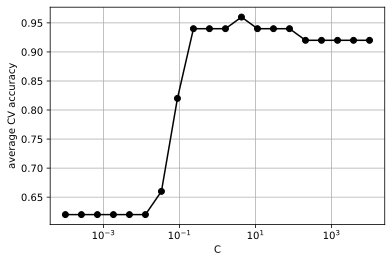

In [33]:
print("C =", logreg.C_)
# calculate the average score for each C
avgscores = mean(logreg.scores_[2],0)  # 2 is the class label
plt.semilogx(logreg.Cs_, avgscores, 'ko-')
plt.xlabel('C'); plt.ylabel('average CV accuracy'); plt.grid(True);

# Multi-class classification
- So far, we have only learned a classifier for 2 classes (+1, -1)
  - called a **binary classifier**
- For more than 2 classes, split the problem up into several binary classifier problems.
  - **1-vs-rest** 
    - _Training:_ for each class, train a classifier for that class versus the other classes.  
      - For example, if there are 3 classes, then train 3 binary classifiers:  1 vs {2,3}; 2 vs {1,3}; 3 vs {1,2}
    - _Prediction:_ calculate probability for each binary classifier.  Select the class with highest probability.

# Example on 3-class Iris data

In [34]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris3.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (setosa=0, versicolor=1, virginica=2)

print(X.shape)

(150, 2)


In [35]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.5, test_size=0.5, random_state=4487)

print(trainX.shape)
print(testX.shape)

(75, 2)
(75, 2)


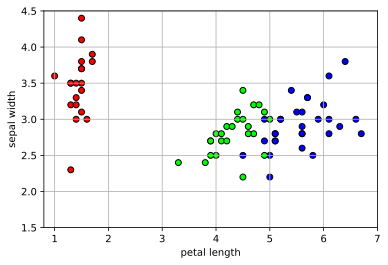

In [36]:
# look at training data

axbox3 = [0.8, 7, 1.5, 4.5]
# make a colormap for viewing 3 classes
mycmap3 = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#00FF00", "#0000FF"])

plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap3, edgecolors='k')
plt.axis(axbox3); plt.grid(True);
plt.xlabel('petal length'); plt.ylabel('sepal width');

In [37]:
# learn logistic regression classifier (one-vs-all)
mlogreg = linear_model.LogisticRegression(C=10, multi_class='ovr')
mlogreg.fit(trainX, trainY)

# now contains 3 hyperplanes and 3 bias terms (one for each class)
print("w=", mlogreg.coef_)
print("b=", mlogreg.intercept_)

# predict from the model
predY = mlogreg.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print("test accuracy=", acc)

w= [[-3.54884501  1.11513222]
 [-0.03185278 -2.23119433]
 [ 5.41926127 -1.69411622]]
b= [  6.26247277   6.1229662  -21.79941354]
test accuracy= 0.9733333333333334


In [38]:
def plot_1vr_classifiers(logreg, mlogreg, axbox, mycmap, trainX, trainY, titstr):
    # plot each classifier (assume 3)
    for i in range(3):
        plt.subplot(1,3,i+1)
        # make binary model
        ilogreg = linear_model.LogisticRegression(logreg)
        ilogreg.coef_ = mlogreg.coef_[i,:].reshape(1,2)
        ilogreg.intercept_ = mlogreg.intercept_[i].reshape(1,) 
        ilogreg.classes_ = array([1, 2])
        itrainY = (trainY == i)
        
        plot_posterior(ilogreg, axbox, mycmap, showlabels=False)
        plt.scatter(trainX[:,0], trainX[:,1], c=itrainY, cmap=mycmap, edgecolors='k')

        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        plt.title(titstr.format(i))

mlrfig = plt.figure(figsize=(9,6))
plot_1vr_classifiers(logreg, mlogreg, axbox3, mycmap, trainX, trainY, "class {} vs. rest")
plt.close()

- the individual 1-vs-rest binary classifiers

w= [[-3.54884501  1.11513222]
 [-0.03185278 -2.23119433]
 [ 5.41926127 -1.69411622]]
b= [  6.26247277   6.1229662  -21.79941354]


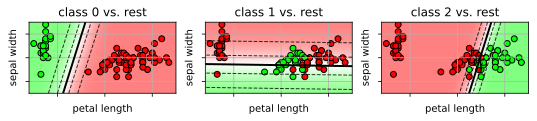

In [39]:
print("w=", mlogreg.coef_)
print("b=", mlogreg.intercept_)

mlrfig 

In [40]:
def plot_posterior3(model, axbox, mycmap):    
    xr = [ arange(0.8,7,0.05) , arange(1.5, 4.5, 0.05) ]
        
    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # predict probabilities
    Z = model.predict_proba(allpts)
    P = model.predict(allpts)

    # use probabilities as RGB color
    ZZ = Z.reshape((len(xr[1]), len(xr[0]), 3))

    plt.imshow(ZZ, origin='lower', extent=axbox, alpha=0.50)
    plt.contour(xr[0], xr[1], P.reshape(xgrid0.shape), levels=[0.5,1.5,2.5], linestyles='dashed', colors='black')
    irisaxis(axbox)
    
lr3class = plt.figure()
plot_posterior3(mlogreg, axbox3, mycmap3)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap3, edgecolors='k')
plt.title('class probabilities');
plt.close()

- the final classifier, combining all 1 vs rest classifiers

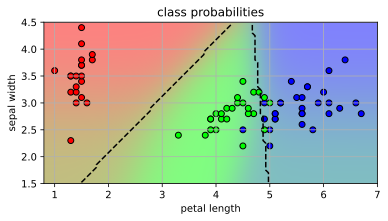

In [41]:
lr3class

# Multiclass logistic regression
- Another way to get a multi-class classifier is to define a multi-class objective.
  - One weight vector $\mathbf{w}_c$ for each class c.
  - linear function for each class, $f_c(\mathbf{x}) = \mathbf{w}_c^T\mathbf{x}$.
- Define probabilities with **softmax** function
  - analogous to sigmoid function for binary logistic regression.
 $$p(y=c|\mathbf{x}) = \frac{e^{f_c(\mathbf{x})}}{e^{f_1(\mathbf{x})} + \cdots + e^{f_K(\mathbf{x})}}$$
  - The class with largest response of $f_c(\mathbf{x})$ will have the highest probability.


In [42]:
f1 = linspace(-5,5,101)
f2 = linspace(-5,5,101)

sfmfig = plt.figure(figsize=(10,4))
for i,f3 in enumerate([-1,3]):
    xgrid0, xgrid1 = meshgrid(f1, f2)
    plt.subplot(1,2,i+1)
    p = exp(xgrid0) / (exp(xgrid0) + exp(xgrid1)+exp(f3))

    plt.imshow(p, origin='lower', extent=[-5,5,-5,5], vmin=0, vmax=1)
    plt.colorbar(shrink=0.8)
    CS = plt.contour(f1, f2, p, colors='k', linestyles='dashed', levels=[0.1, 0.3, 0.5, 0.7, 0.9], alpha=0.8, linewidths=1)

    plt.clabel(CS, inline=1, fontsize=10)

    plt.xlabel('$f_1$')
    plt.ylabel('$f_2$')
    plt.title('$p(y=1|\mathbf{x})$, $f_3=' + str(f3) + '$')
plt.close()

- Example with $K=3$.
 $$p(y=1|\mathbf{x}) = \frac{e^{f_1(\mathbf{x})}}{e^{f_1(\mathbf{x})} + e^{f_2(\mathbf{x})} + e^{f_3(\mathbf{x})}}$$

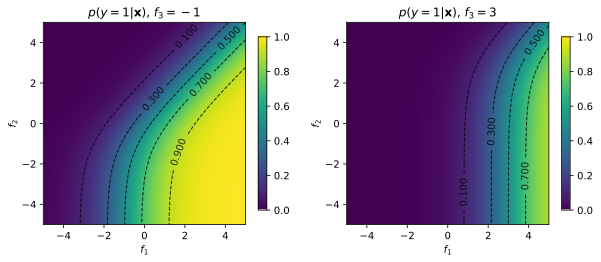

In [43]:
sfmfig

# Parameter estimation

- Estimate the $\{\mathbf{w}_j\}$ parameters using MLE.
- Let $(\mathbf{x}, \mathbf{y})$ be a data sample pair:
  - $\mathbf{x}$ feature vector.
  - $\mathbf{y} = [y_1, \cdots, y_K]$ is a one-hot vector, where $y_c=1$ when class $c$, and 0 otherwise.
- Data likelihood of $(\mathbf{x}, \mathbf{y})$.
     $$\begin{aligned}\text{likelihood:}&&p(\mathbf{y}|\mathbf{x}) &= \prod_{j=1}^K p(y=j|\mathbf{x})^{y_j} \\
  \text{log-likelihood:}&& \log p(\mathbf{y}|\mathbf{x}) &= \sum_{j=1}^K y_j \log p(y=j|\mathbf{x}) \\
  \text{negative log-likelihood:}&&  -\log p(\mathbf{y}|\mathbf{x}) &= -\sum_{j=1}^K y_j \log p(y=j|\mathbf{x})\end{aligned}$$
  - equivalent to the *cross-entropy loss*

- Given dataset $\{(\mathbf{x}_i, \mathbf{y}_i)\}_{i=1}^N$
  - maximize the data log-likelihood:
  $$\max_{\{\mathbf{w}_j\}} \sum_{i=1}^N \log p(\mathbf{y}_i|\mathbf{x}_i) = 
  \max_{\{\mathbf{w}_j\}} \sum_{i=1}^N \sum_{j=1}^K y_{ij} \log p(y=j|\mathbf{x}_i)
  $$
  - i.e., minimize the cross-entropy loss

In [44]:
# learn logistic regression classifier
mlogreg = linear_model.LogisticRegression(C=10, 
            multi_class='multinomial')  
            # use multi-class and corresponding solver
mlogreg.fit(trainX, trainY)

# now contains 3 hyperplanes and 3 bias terms (one for each class)
print("w=", mlogreg.coef_)
print("b=", mlogreg.intercept_)

# predict from the model
predY = mlogreg.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print("test accuracy=", acc)

w= [[-4.13092437  1.30718735]
 [-0.71717021  0.23609022]
 [ 4.84809458 -1.54327757]]
b= [ 11.46078594   5.40723484 -16.86802078]
test accuracy= 0.9733333333333334


In [45]:
lr3classm = plt.figure()
plot_posterior3(mlogreg, axbox3, mycmap3)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap3, edgecolors='k')
plt.title('class probabilities');
plt.close()

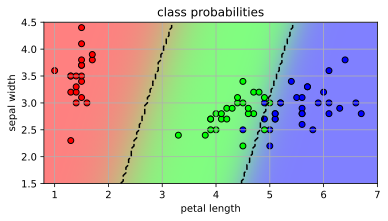

In [46]:
lr3classm

In [47]:
lr31vr = plt.figure(figsize=(9,6))
plot_1vr_classifiers(logreg, mlogreg, axbox3, mycmap, trainX, trainY, "w{}")
plt.close()

/Users/abc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: No contour levels were found within the data range.


- individual weight vectors work together to partition the space

w= [[-4.13092437  1.30718735]
 [-0.71717021  0.23609022]
 [ 4.84809458 -1.54327757]]
b= [ 11.46078594   5.40723484 -16.86802078]


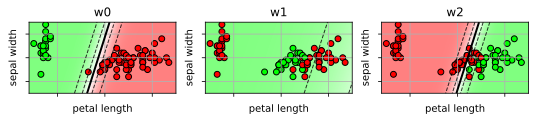

In [48]:
print("w=", mlogreg.coef_)
print("b=", mlogreg.intercept_)

lr31vr

# Logistic Regression Summary
- **Classifier:**
  - linear function $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b$
  - Given a feature vector $\mathbf{x}$, the probability of a class is:
    - $p(y=+1|\mathbf{x}) = \sigma( f(\mathbf{x}) )$
    - $p(y=-1|\mathbf{x}) = 1-\sigma( f(\mathbf{x}) )$
    - _sigmoid_ function: $\sigma(z) = \frac{1}{1+e^{-z}}$
  - logistic loss function: $L(z) = \log (1+\exp(-z))$
- **Training:**
  - Maximize the likelihood of the training data.
  - Use regularization to prevent overfitting.
    - Use cross-validation to pick the regularization hyperparameter $C$.

- **Classification:**
  - Given a new sample $\mathbf{x}^*$:
    - pick class with highest probability $p(y|\mathbf{x}^*)$:
      $$y^*=\begin{cases}+1, p(y=+1|\mathbf{x}^*)>p(y=-1|\mathbf{x}^*) \\ -1, \mathrm{otherwise}\end{cases}$$
    - alternatively, just use $f(\mathbf{x}^*)$
      $$y^* = \begin{cases}+1, f(\mathbf{x}^*)>0 \\ -1, \mathrm{otherwise}\end{cases} = \mathrm{sign}(f(\mathbf{x}_*))$$
- **Extend to multi-class:**
  - $K$ linear functions, one for each class.
  - compute probability using softmax function
  - MLE equivalent to cross-entropy loss

